In [104]:
import os
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten,BatchNormalization,Conv2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix

from mpl_toolkits.axes_grid1 import ImageGrid

import itertools

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Import OpenCV
import cv2

from os import listdir
from os.path import isfile, join 

from keras.callbacks import EarlyStopping

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [68]:
# https://github.com/abhinav23dixit/Waste-Classification

# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

# plot image
# https://www.tensorflow.org/tutorials/images/classification
# https://github.com/msminhas93/KerasImageDatagenTutorial/blob/master/DataGenTutorial.ipynb

# confusion matrix
# https://www.kaggle.com/paoloripamonti/derma-diseases

In [69]:
base_dir = 'Recycling_Data_V1'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')
predict_dir = os.path.join(base_dir, 'Predict')

In [70]:
# ResNet50 image size
IMAGE_SIZE = (256,256)
INPUT_SHAPE = (256,256,3)

# Keras settings
TRAIN_BATCH_SIZE = 20
VALDATION_BATCH_SIZE = 20
TEST_BATCH_SIZE = 20

STEPS_PER_EPOCHS = 50
EPOCHS = 15
VALIDATION_STEPS = 228

LEARNING_RATE = 0.0001 

In [71]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

In [72]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=IMAGE_SIZE,  # All images will be resized to 150x150
        batch_size=TRAIN_BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=IMAGE_SIZE,
        batch_size=VALDATION_BATCH_SIZE,
        class_mode='categorical')


# Flow test images in batches of 20 using train_datagen generator
test_generator = test_datagen.flow_from_directory(
        directory=test_dir,  # This is the source directory for training images
        target_size=IMAGE_SIZE,  # All images will be resized to 150x150
        batch_size=TEST_BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        shuffle=False)


Found 1262 images belonging to 6 classes.
Found 630 images belonging to 6 classes.
Found 635 images belonging to 6 classes.


In [73]:
# classes training

train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [74]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}
class_mapping

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [75]:
type(class_mapping)

dict

In [76]:
x,y = next(train_generator) 
y_int = np.argmax(y,axis=-1)

## Plot Methods

In [77]:
def plot(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')
        

def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())
     
    plt.figure(figsize=(10,10))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

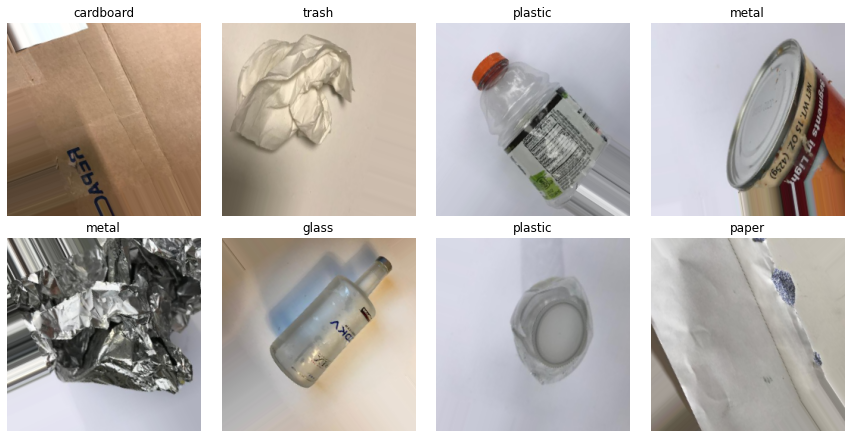

In [78]:
plot(x,2,4,label_list=y_int,show_labels=True,figsize=(15,10))

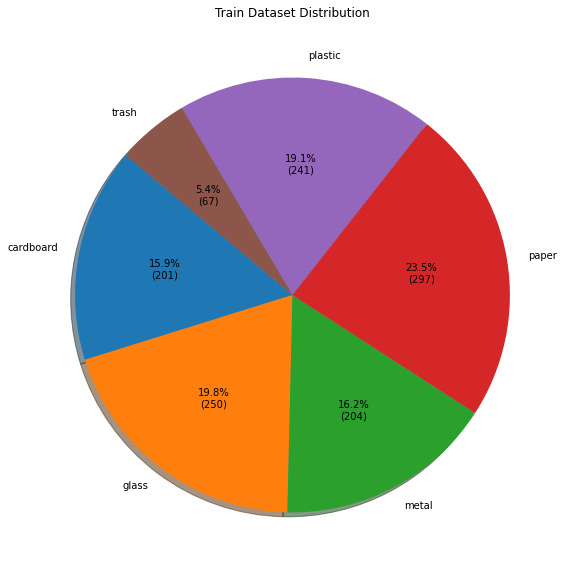

In [79]:
# Train dataset plot
plot_dataset(os.path.join(train_dir), "Train Dataset Distribution")


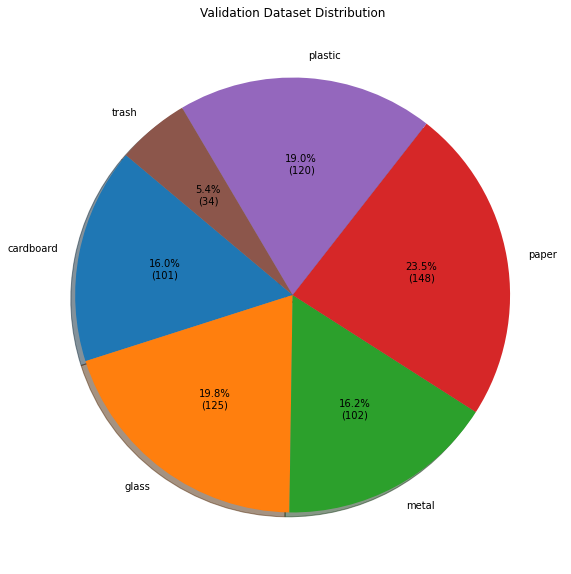

In [80]:
# Validation dataset plot
plot_dataset(os.path.join(validation_dir), "Validation Dataset Distribution")             

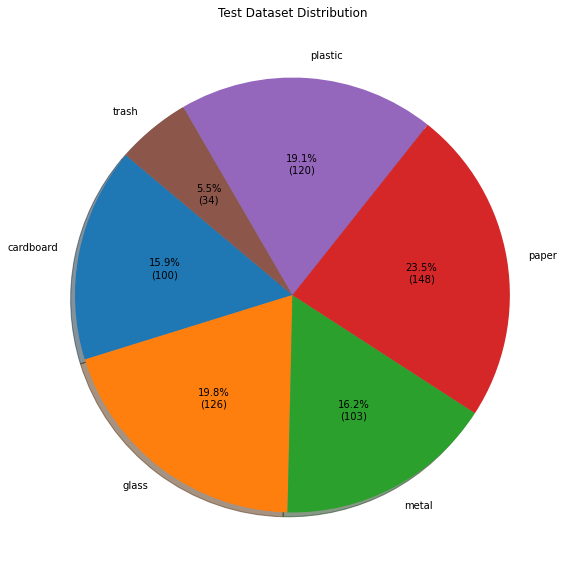

In [81]:
# Test dataset plot
plot_dataset(os.path.join(test_dir), "Test Dataset Distribution")

## Model

In [105]:
classifier = Sequential()

classifier.add(Convolution2D(32,(3,3),input_shape=INPUT_SHAPE,activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Convolution2D(64, (3, 3),activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Convolution2D(128, (3, 3),activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Convolution2D(128, (3, 3),activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))
 

In [83]:
classifier.add(Flatten())

classifier.add(Dropout(0.5))
                
classifier.add(Dense(output_dim=512,activation='relu'))
classifier.add(Dense(output_dim=6,activation='softmax'))

classifier.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# classifier.add(Flatten()) 

# classifier.add(Dense(output_dim=2048,activation='relu'))
# classifier.add(Dense(output_dim=2048,activation='relu'))
# classifier.add(Dense(output_dim=6,activation='softmax'))

# classifier.compile(optimizer='adam',
#                    loss='categorical_crossentropy',
#                    metrics=['accuracy'])

In [84]:
# history=classifier.fit_generator(train_generator,
#                     steps_per_epoch=STEPS_PER_EPOCHS,
#                     epochs=EPOCHS,
#                     validation_data=validation_generator,
#                     validation_steps=VALIDATION_STEPS,callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

history=classifier.fit_generator(train_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_data=validation_generator,validation_steps=100,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/20
100/100 [==============================] - 385s 4s/step - loss: 4.3660 - accuracy: 0.4077 - val_loss: 3.4898 - val_accuracy: 0.2665
Epoch 2/20
100/100 [==============================] - 355s 4s/step - loss: 1.6344 - accuracy: 0.4681 - val_loss: 2.5914 - val_accuracy: 0.2462
Epoch 3/20
100/100 [==============================] - 357s 4s/step - loss: 1.2902 - accuracy: 0.5540 - val_loss: 1.7318 - val_accuracy: 0.2904
Epoch 4/20
100/100 [==============================] - 317s 3s/step - loss: 1.1926 - accuracy: 0.5743 - val_loss: 1.8150 - val_accuracy: 0.3249
Epoch 5/20
100/100 [==============================] - 345s 3s/step - loss: 1.1526 - accuracy: 0.5880 - val_loss: 1.6936 - val_accuracy: 0.4944
Epoch 6/20
100/100 [==============================] - 375s 4s/step - loss: 1.1328 - accuracy: 0.6034 - val_loss: 1.9915 - val_accuracy: 0.4310
Epoch 7/20
100/100 [==============================] - 374s 4s/step - loss: 1.0450 - accuracy: 0.6283 - val_loss: 3.9675 - val_accuracy: 0.2619

In [85]:
# Performance matrix 
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

val_loss  val_accuracy      loss  accuracy  epoch
0    3.489831      0.266497  4.395882  0.407669      0
1    2.591425      0.246193  1.634448  0.468140      1
2    1.731767      0.290355  1.282565  0.553986      2
3    1.815029      0.324873  1.187902  0.574338      3
4    1.693605      0.494416  1.152611  0.588000      4
5    1.991516      0.430964  1.123523  0.603360      5
6    3.967469      0.261929  1.044531  0.628310      6
7    1.016024      0.564796  0.917019  0.670535      7
8    0.768013      0.618274  0.906696  0.681263      8
9   13.631979      0.260406  0.972369  0.656314      9
10   5.272396      0.462437  0.830678  0.705853     10
11   1.879482      0.448731  0.807898  0.711813     11
12   0.987495      0.427919  0.813379  0.715439     12
13   1.060126      0.556345  0.810910  0.716395     13

## Training and Validation dataset performance

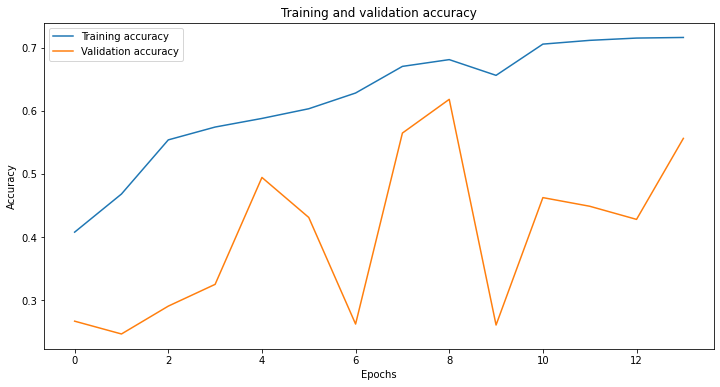

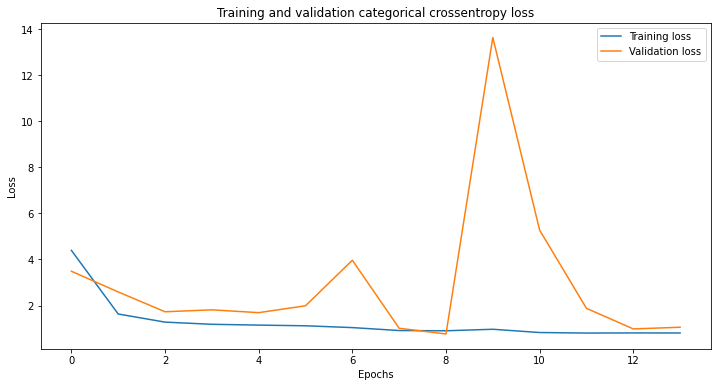

In [86]:
# Graph: Training and Validation dataset performance

plt.rcParams['figure.figsize'] = (12.0, 6.0)

def plot_cnn_performance(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and validation categorical crossentropy loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_cnn_performance(history)

In [87]:
#Evaluate model performance on validation dataset

score = classifier.evaluate_generator(validation_generator)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 1.2376291751861572
Validation accuracy: 0.5539682507514954


In [88]:
#Evaluate model performance on training dataset

score = classifier.evaluate_generator(train_generator)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.19949355721473694
Train accuracy: 0.5332804918289185


In [89]:
loss, accuracy = classifier.evaluate_generator(test_generator,
            steps=test_generator.samples//test_generator.batch_size)

In [90]:
print("Accuracy: %f\nLoss: %f" % (accuracy,loss))

Accuracy: 0.598387
Loss: 2.543413


In [91]:
predict=classifier.predict_generator(test_generator)

In [92]:
y_pred = np.argmax(predict, axis=1)

In [93]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)
cnf_matrix

array([[76,  5, 11,  1,  5,  3],
       [ 1, 91, 15,  0, 15,  4],
       [ 0, 18, 74,  1,  3,  7],
       [12, 10, 42, 63, 13,  9],
       [ 1, 35, 20,  0, 56,  9],
       [ 0, 10,  1,  1,  4, 19]], dtype=int64)

In [94]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

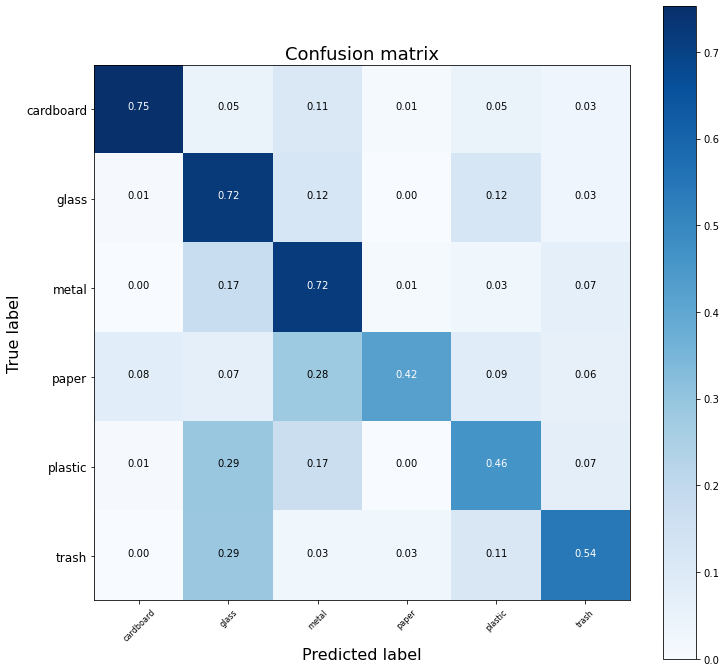

In [95]:
plot_confusion_matrix(cnf_matrix, list(class_mapping.values()))

In [96]:
print(classification_report(test_generator.classes, y_pred, target_names=list(class_mapping.values())))

              precision    recall  f1-score   support

   cardboard       0.84      0.75      0.80       101
       glass       0.54      0.72      0.62       126
       metal       0.45      0.72      0.56       103
       paper       0.95      0.42      0.59       149
     plastic       0.58      0.46      0.52       121
       trash       0.37      0.54      0.44        35

    accuracy                           0.60       635
   macro avg       0.62      0.60      0.59       635
weighted avg       0.67      0.60      0.60       635



## Predict New Images

In [97]:
def load_image(filename):
    img = cv2.imread(os.path.join(predict_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255    
    return img

def predict(image):
    probabilities = classifier.predict(np.asarray([image]))[0]
    class_idx = np.argmax(probabilities)    
    return {class_mapping[class_idx]: probabilities[class_idx]}

In [98]:
# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]

Image Name -  glass107.jpg
Predicted Class - class: metal, Predicted Confidence: 0.559230


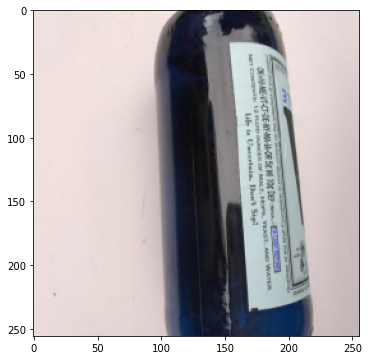

Image Name -  glass32.jpg
Predicted Class - class: plastic, Predicted Confidence: 0.386382


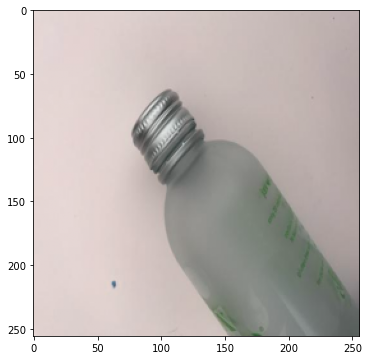

Image Name -  metal182.jpg
Predicted Class - class: glass, Predicted Confidence: 0.964288


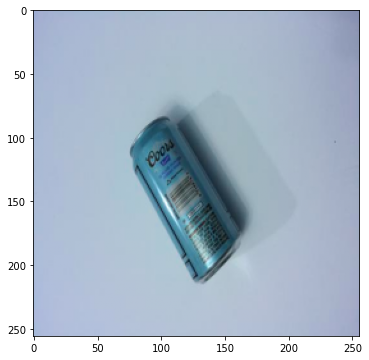

Image Name -  metal223.jpg
Predicted Class - class: glass, Predicted Confidence: 0.461594


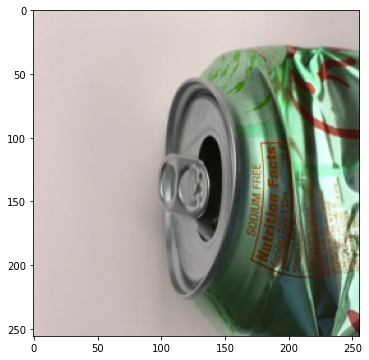

Image Name -  metal81.jpg
Predicted Class - class: paper, Predicted Confidence: 0.449409


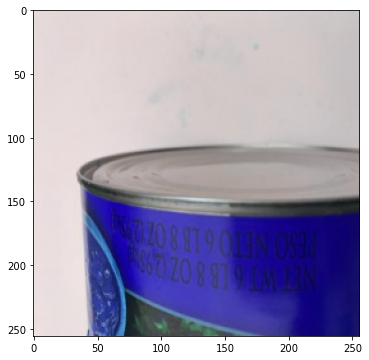

Image Name -  metal97.jpg
Predicted Class - class: metal, Predicted Confidence: 0.390282


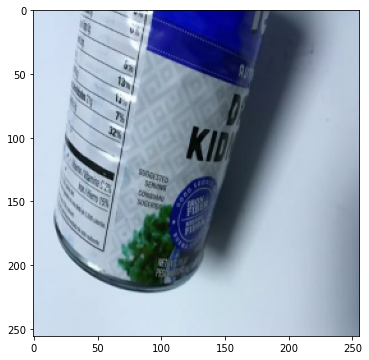

Image Name -  plastic166.jpg
Predicted Class - class: glass, Predicted Confidence: 0.969970


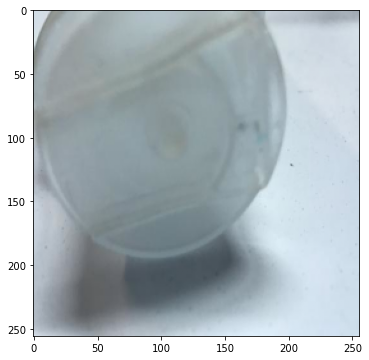

Image Name -  plastic172.jpg
Predicted Class - class: plastic, Predicted Confidence: 0.768202


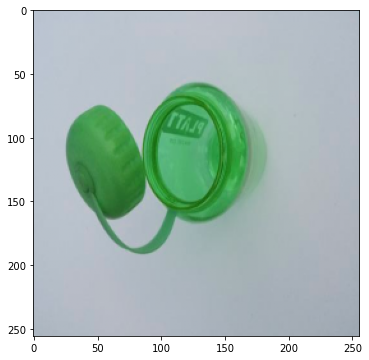

Image Name -  plastic209.jpg
Predicted Class - class: glass, Predicted Confidence: 0.417747


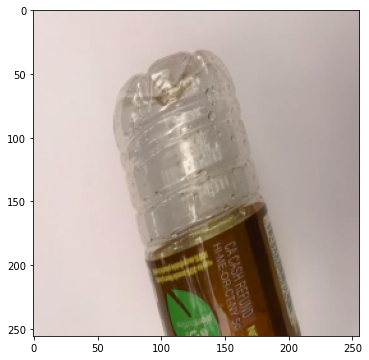

Image Name -  plastic218.jpg
Predicted Class - class: glass, Predicted Confidence: 0.398445


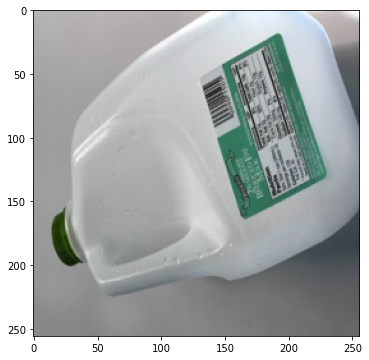

Image Name -  plastic449.jpg
Predicted Class - class: glass, Predicted Confidence: 0.621296


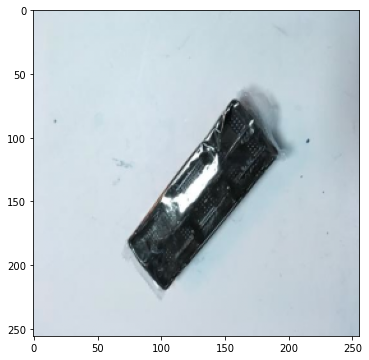

Image Name -  plastic453.jpg
Predicted Class - class: glass, Predicted Confidence: 0.748255


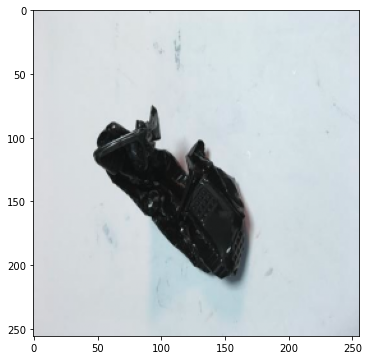

Image Name -  trash10.jpg
Predicted Class - class: glass, Predicted Confidence: 0.479770


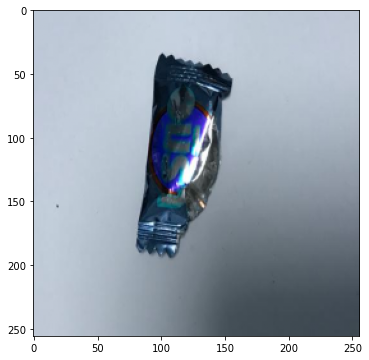

Image Name -  trash102.jpg
Predicted Class - class: glass, Predicted Confidence: 0.959918


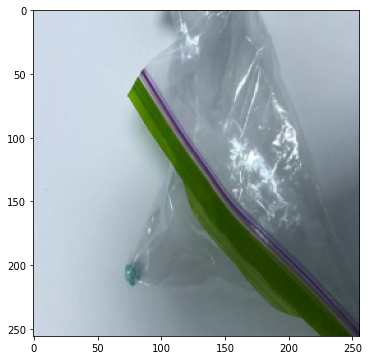

Image Name -  trash109.jpg
Predicted Class - class: glass, Predicted Confidence: 0.531195


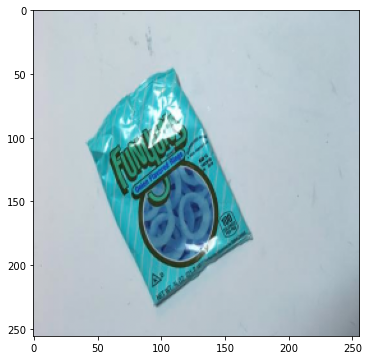

Image Name -  trash118.jpg
Predicted Class - class: glass, Predicted Confidence: 0.643696


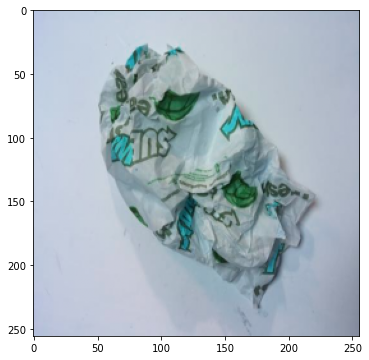

Image Name -  trash15.jpg
Predicted Class - class: metal, Predicted Confidence: 0.743221


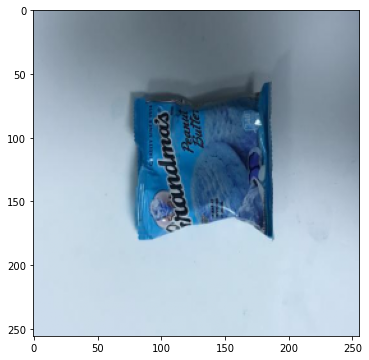

Image Name -  trash60.jpg
Predicted Class - class: glass, Predicted Confidence: 0.898876


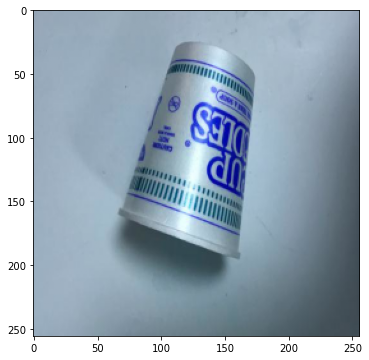

Image Name -  trash8.jpg
Predicted Class - class: glass, Predicted Confidence: 0.956696


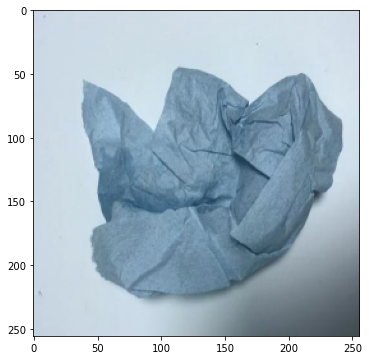

In [99]:
# load image path to predict
# onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]


for image_file in onlyfiles:
    print("Image Name - ", image_file);
    img = load_image(image_file)
    prediction = predict(img)
    print("Predicted Class - class: %s, Predicted Confidence: %f" 
          % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)  
    plt.show()    
    

In [100]:
classifier.save('model_test_v1.h5')

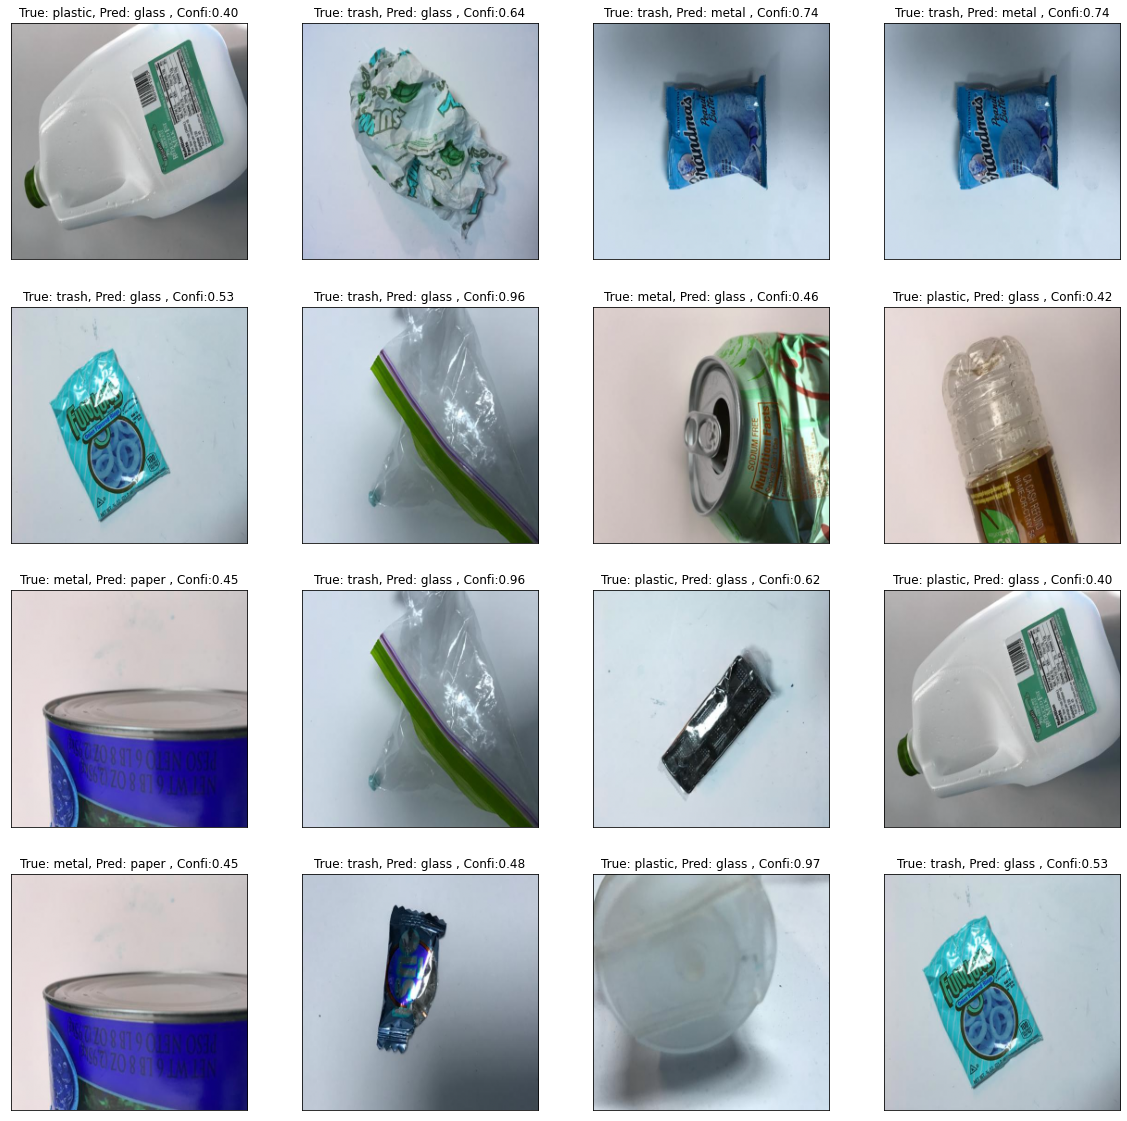

In [101]:
# Plot function 

def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'
    elif "trash" in filename:
        return 'trash'

def plot_predicted_label_1(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 20))
    
    rs = np.random.choice(len(onlyfiles), nrows*ncols)
    
    for i, ax in zip(rs, axes.flat):
        img = load_image(onlyfiles[i])
        true_type = image_type(onlyfiles[i])
        prediction = predict(img)
     
        title = 'True: %s, Pred: %s , Confi:%0.2f' % (true_type,list(prediction.keys())[0],list(prediction.values())[0])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])
        
# ploat image with predicted and actual value
num_rows = 4
num_cols = 4
plot_predicted_label_1(num_rows, num_cols,onlyfiles);

In [102]:
# import pickle

In [103]:
# model_path =  "../WasteSortingApp/waste_image_classifier.pk"
# pickle.dump(classifier, open(model_path,"wb"))